In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib, statsmodels, scipy, random, glob, sklearn, csv, itertools
matplotlib.style.use('seaborn-muted')

from matplotlib import *
from matplotlib import collections as mc
from scipy import stats
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.stats as smstats
from sklearn.decomposition import PCA
import matplotlib.gridspec as gridspec

from collections import Counter, defaultdict

base_dir = '/Users/sadamson/Desktop/scripts_and_such/Vex-seq/RBP_pool/Github_repo/'
figure_out_dir = '/Users/sadamson/Desktop/scripts_and_such/Vex-seq/RBP_pool/figures/'

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

sns.set_style("whitegrid")

%matplotlib inline
def progress_bar(i, max_i):
    sys.stdout.write('\r')
    j = (i+1)/max_i
    sys.stdout.write("[%-20s] %d%%" % ('='*int(20*j), 100*j))
    sys.stdout.flush()

# Vex-seq QC #

Skew ratio:  7.749999999999999
Barcode sequences dropped out:  825
Percent barcode sequences dropped out:  0.825404448179608


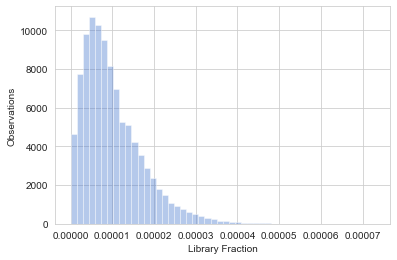

In [2]:
# Plasmid read depth distribution
plasmid_df = pd.read_csv(base_dir + 'preprocessed_data/2o_plasmid_quantifications.tsv', sep = '\t')
plasmid_df['group_id'] = plasmid_df.loc[:,'barcode'].str.split('_').str[0]
plasmid_df['barcode_string'] = plasmid_df.loc[:,'barcode'].str.split('_').str[1]

plasmid_df = plasmid_df.sort_values(by=['mapped_read_pairs'], ascending = False).reset_index(drop=True)
plasmid_df['mapped_read_pairs'] = plasmid_df.loc[:,'mapped_read_pairs']/plasmid_df.loc[:,'mapped_read_pairs'].sum()

sns.distplot(plasmid_df.loc[:,'mapped_read_pairs'], kde = False)

top_10 = np.percentile(plasmid_df.loc[:,'mapped_read_pairs'], 90)
bottom_10 = np.percentile(plasmid_df.loc[:,'mapped_read_pairs'], 10)
print('Skew ratio: ', top_10/bottom_10)
plt.ylabel('Observations')
plt.xlabel('Library Fraction')
print('Barcode sequences dropped out: ', plasmid_df[plasmid_df.loc[:,'mapped_read_pairs'] ==0].shape[0])
print('Percent barcode sequences dropped out: ', plasmid_df[plasmid_df.loc[:,'mapped_read_pairs'] ==0].shape[0]*100/plasmid_df.shape[0])
plt.ticklabel_format(style = 'plain')

#plt.savefig(figure_out_dir + 'Supplemental_Figure_2A_barcode_ratio.svg')
#plt.savefig(figure_out_dir + 'Supplemental_Figure_2A_barcode_ratio.png')

Text(0, 0.5, 'Observations')

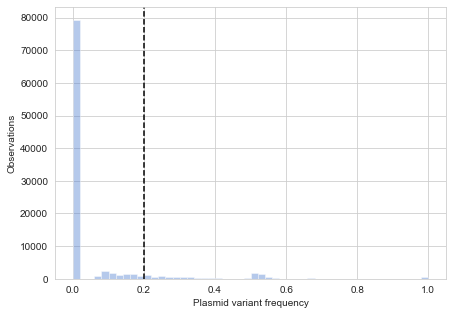

In [3]:
threshold = []; barcodes = []
plasmid_df = pd.read_csv(base_dir + 'preprocessed_data/1o_plasmid_VAFs.tsv', sep = '\t')
fig, ax = plt.subplots(1,1, figsize = (7,5))

sns.distplot(plasmid_df.loc[:,'variant_max_AF'],ax = ax, kde = False)
ax.axvline(0.2, color = 'black', linestyle = '--')
ax.set_xlabel('Plasmid variant frequency')
ax.set_ylabel('Observations')

#plt.savefig(figure_out_dir + 'Supplemental_Figure_2B_barcode_variant_frequency.svg')
#plt.savefig(figure_out_dir + 'Supplemental_Figure_2B_barcode_variant_frequency.png')

# Splicing QC #

In [4]:
def unify_event_id(event_id):
    #143;SE:143:44-225:305-1004:+
    ref_id = var2ref[event_id.split(';')[0]]
    new_event_id = ref_id + ';SE:' + ref_id + ':' + ':'.join(event_id.split(':')[2:])
    return new_event_id

var2ref = {}
a = open(base_dir + 'preprocessed_data/ref2var.tsv', 'r')
reader = csv.reader(a, delimiter ='\t')
for line in reader:
    for var in line[1].split(','):
        var2ref[var] = line[0]
    var2ref[line[0]] = line[0]
a.close()

def setup_suppa_df(cell_line):
    suppa_df = pd.read_csv(base_dir + 'preprocessed_data/' + cell_line + '_suppa_postprocessed.tsv', sep = '\t')
    suppa_df['corrected_pval'] = smstats.multitest.multipletests(suppa_df.loc[:,'pval'], method = 'fdr_bh')[1]
    suppa_df = suppa_df[suppa_df.loc[:,'delta_psi'].isna() == False]

    SE_info = pd.read_csv(base_dir + 'preprocessed_data/suppa_MaxEntScan_info_SE.tsv', sep = '\t')

    suppa_df_SE = suppa_df.merge(SE_info, on = ['group_id', 'event_id'])
    suppa_df_SE = suppa_df_SE[(suppa_df_SE.loc[:,'event_class'] == 'SE')]

    sequence_design_info = pd.read_csv(base_dir + 'preprocessed_data/SRE_pool_sequences_dups_hg19.tsv', sep = '\t')
    keeper_cols = ('chromosome', 'position', 'reference', 'alternative', 'intron_lower', 'intron_upper', 'exon_start',
                  'exon_end', 'control', 'group_id')
    sequence_design_info = sequence_design_info.loc[:,keeper_cols].drop_duplicates()
    sequence_design_info = sequence_design_info.groupby(by = ['control', 'group_id']).first().reset_index()
    sequence_design_info = sequence_design_info.loc[:,('control','reference', 'alternative', 'position', 'group_id', 'intron_lower', 'intron_upper', 'exon_start','exon_end')]
    sequence_design_info['RBP_source'] = sequence_design_info.loc[:,'control'].str.split('|').str[0]
    suppa_df_SE = sequence_design_info.merge(suppa_df_SE, on = 'group_id')
    suppa_df = None

    suppa_df_SE['unified_event_id'] = suppa_df_SE.loc[:,'event_id'].apply(unify_event_id)

    chunk_df = pd.read_csv(base_dir + 'preprocessed_data/group_id_to_chunk.tsv', sep = '\t')
    chunk_dict = dict(zip(chunk_df.loc[:,'group_id'], chunk_df.loc[:,'chunk_id']))
    suppa_df_SE['chunk_id'] = suppa_df_SE.loc[:,'group_id'].map(chunk_dict)
    suppa_df_SE = suppa_df_SE[suppa_df_SE.loc[:,'annotated'] == True]

    return suppa_df_SE

K562_suppa_SE_df = setup_suppa_df('K562')
HepG2_suppa_SE_df = setup_suppa_df('HepG2')


In [5]:
def rename_merge(df1, df2, sample_2):
    old_cols = list(df2.columns)
    replace_dict = dict(zip(['ref_psi', 'var_psi', 'delta_psi', 'corrected_pval'],
                        [sample_2 + '_ref_psi', sample_2 + '_var_psi', sample_2 + '_delta_psi', sample_2 + '_corrected_pval']))
    new_cols = []
    for col in old_cols:
        if col not in replace_dict:
            new_cols.append(col)
        else:
            new_cols.append(replace_dict[col])
    df2.columns = new_cols
    merged_df = df1.merge(df2.loc[:,('group_id', 'control', 'unified_event_id', 
                                     sample_2 + '_ref_1', sample_2 + '_ref_2', sample_2 + '_ref_3', 
                                     sample_2 + '_var_1', sample_2 + '_var_2', sample_2 + '_var_3',
                                     sample_2 + '_ref_psi', sample_2 + '_var_psi', sample_2 + '_delta_psi', sample_2 + '_corrected_pval')],
                         how = 'left', on = ['group_id', 'control', 'unified_event_id'])
    return merged_df
total_df = HepG2_suppa_SE_df.copy()
total_df = total_df.rename(columns = dict(zip(['ref_psi', 'var_psi', 'delta_psi', 'corrected_pval'],
                        ['HepG2_ref_psi', 'HepG2_var_psi', 'HepG2_delta_psi', 'HepG2_corrected_pval'])))
total_df = rename_merge(total_df, K562_suppa_SE_df, 'K562')
#total_df = rename_merge(total_df, K562_NT_suppa_SE_df, 'K562_NT')
#total_df = rename_merge(total_df, K562_UPF1_suppa_SE_df, 'K562_UPF1')
total_df.head()

,control,reference,alternative,position,group_id,intron_lower,intron_upper,exon_start,exon_end,RBP_source,...,K562_ref_1,K562_ref_2,K562_ref_3,K562_var_1,K562_var_2,K562_var_3,K562_ref_psi,K562_var_psi,K562_delta_psi,K562_corrected_pval
0,AKAP8L_K562|22255_SE,CC,CT,1011230,12,1011074,1011245,1011094,1011194,AKAP8L_K562,...,0.54032,2.41845,0.0,4.380386,3.487118,0.000000,0.986257,2.622501,1.636245,0.468371
1,AKAP8L_K562|22255_SE,CC,CA,1011230,76,1011074,1011245,1011094,1011194,AKAP8L_K562,...,0.54032,2.41845,0.0,10.715056,5.798454,4.725186,0.986257,7.079565,6.093309,0.370933
2,AKAP8L_K562|22255_SE,TG,TT,1011237,97,1011074,1011245,1011094,1011194,AKAP8L_K562,...,0.54032,2.41845,0.0,2.961721,0.000000,0.000000,0.986257,0.987240,0.000984,0.570886
3,AKAP8L_K562|22255_SE,CC,AA,1011235,121,1011074,1011245,1011094,1011194,AKAP8L_K562,...,0.54032,2.41845,0.0,1.189982,0.473748,0.326495,0.986257,0.663408,-0.322848,0.551541
4,AKAP8L_K562|22255_SE,GT,CA,1011228,167,1011074,1011245,1011094,1011194,AKAP8L_K562,...,0.54032,2.41845,0.0,5.634065,3.060098,1.429581,0.986257,3.374581,2.388324,0.479947


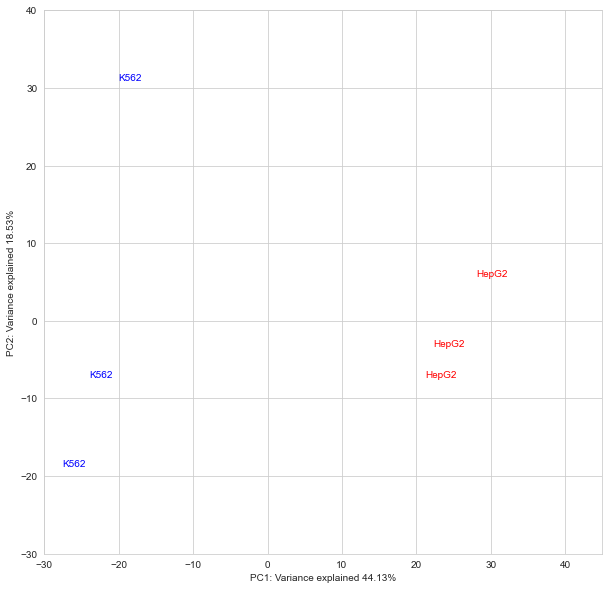

In [6]:
from sklearn import preprocessing
pca = PCA(n_components=2)
samples = ['HepG2_var_1', 'HepG2_var_2', 'HepG2_var_3', 'K562_var_1', 'K562_var_2', 'K562_var_3']#, 
#           'K562_NT_var_1', 'K562_NT_var_2', 'K562_NT_var_3', 'K562_UPF1_var_1', 'K562_UPF1_var_2' ,'K562_UPF1_var_3']

PCA_df = total_df.loc[:,['group_id'] + samples].drop_duplicates() 
PCA_coors = pd.DataFrame(pca.fit_transform(preprocessing.scale(PCA_df.loc[:,samples].dropna()).transpose()))
variance_explained = pca.explained_variance_ratio_
labels = PCA_df.loc[:,samples].dropna().transpose().index
labels = [label[0:-6] for label in labels]
PCA_coors['sample'] = labels

fig,ax = plt.subplots(1,1,figsize = (10,10))
plt.xlim(-30, 45)
plt.ylim(-30, 40)
plt.xlabel('PC1: Variance explained ' + str(round(variance_explained[0]*100, 2))+'%')
plt.ylabel('PC2: Variance explained ' + str(round(variance_explained[1]*100, 2))+'%')
color_dict = dict(zip(['K562', 'HepG2', 'K562_NT', 'K562_UPF1'], ['blue', 'red', 'gray', 'black']))
for index, row in PCA_coors.iterrows():
    color = color_dict[row['sample']]
    plt.text(float(row[0]), float(row[1]), row['sample'], color = color )

plt.show()

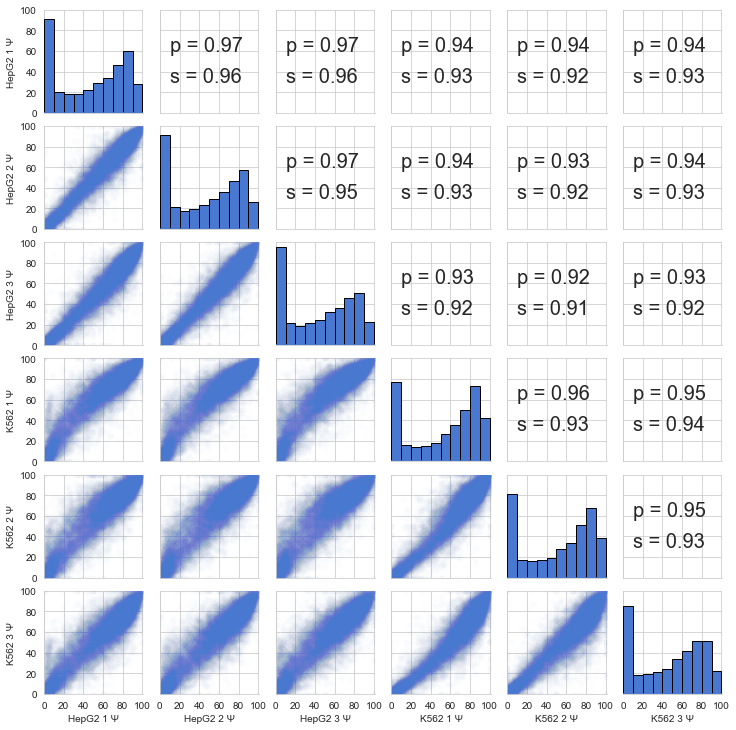

In [7]:
PSI_corr_df = total_df.loc[:,('group_id', 'HepG2_var_1', 'HepG2_var_2', 'HepG2_var_3', 'K562_var_1', 'K562_var_2', 'K562_var_3')].drop_duplicates()
PSI_corr_df = PSI_corr_df.loc[:,('HepG2_var_1', 'HepG2_var_2', 'HepG2_var_3', 'K562_var_1', 'K562_var_2', 'K562_var_3')]
PSI_corr_df.columns = [u"HepG2 1 \u03A8", u"HepG2 2 \u03A8", u"HepG2 3 \u03A8", u"K562 1 \u03A8",
                          u"K562 2 \u03A8",u"K562 3 \u03A8"]
#define spearman and pearson correlation function for graph
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    s, _ = stats.spearmanr(x, y)
    ax = plt.gca()
    ax.annotate("p = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes, size=20)
    ax.annotate("s = {:.2f}".format(s),
                xy=(.1, .3), xycoords=ax.transAxes, size=20)


#set_figure_aesthetics(1.7, 10, 10)
ax = sns.PairGrid(PSI_corr_df.dropna(), aspect = 1)
ax.set(xticks=np.arange(0,101,20))
ax.set(yticks=np.arange(0,101,20))
ax.map_lower(sns.scatterplot, alpha = 0.01)
ax.map_diag(plt.hist, edgecolor="k", linewidth=1)
ax.map_diag(sns.kdeplot)
ax.map_upper(corrfunc)
ax.set(ylim=(0,100));ax.set(xlim=(0,101))
ax.fig.set_size_inches(10,10)

plt.show()
#ax.savefig(figure_out_dir + 'Supplemental_Figure_2C_PSI_correlation.png')

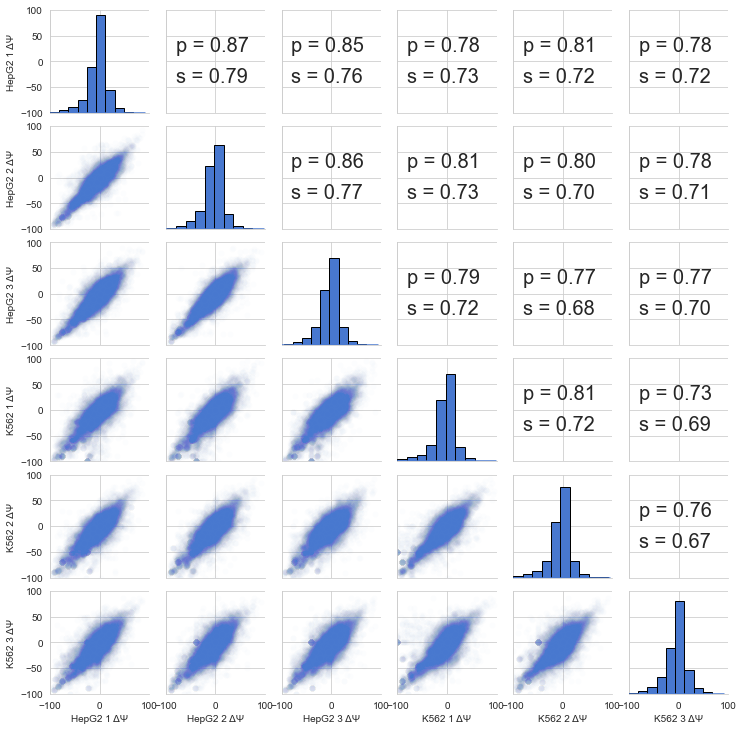

In [8]:
ref_var_samples = ['HepG2_ref_1', 'HepG2_ref_2', 'HepG2_ref_3', 'HepG2_var_1', 'HepG2_var_2', 'HepG2_var_3', 
                   'K562_ref_1', 'K562_ref_2', 'K562_ref_3', 'K562_var_1', 'K562_var_2', 'K562_var_3']
delta_PSI_sample_df = total_df.loc[:,['group_id'] + ref_var_samples].drop_duplicates()

out_samples = []
for cell_line in ['HepG2', 'K562']:
    for rep in ['1','2','3']:
        delta_PSI_sample_df.loc[:,cell_line + '_' + rep + '_dpsi'] = delta_PSI_sample_df.loc[:,cell_line + '_var_' + rep] - delta_PSI_sample_df.loc[:,cell_line + '_ref_' + rep]
        out_samples.append(cell_line + '_' + rep + '_dpsi')
delta_PSI_sample_df = delta_PSI_sample_df.loc[:,out_samples]

delta_PSI_sample_df.columns = [u"HepG2 1 \u0394\u03A8", u"HepG2 2 \u0394\u03A8", u"HepG2 3 \u0394\u03A8", 
                               u"K562 1 \u0394\u03A8", u"K562 2 \u0394\u03A8",u"K562 3 \u0394\u03A8"]

ax = sns.PairGrid(delta_PSI_sample_df.dropna(), aspect = 1)
ax.map_lower(sns.scatterplot, alpha =0.01)
ax.map_diag(plt.hist, edgecolor="k", linewidth=1)
ax.map_diag(sns.kdeplot)
ax.map_upper(corrfunc)
ax.set(ylim=(-100,100));ax.set(xlim=(-100,100))
ax.fig.set_size_inches(10,10)
plt.show()
#ax.savefig(figure_out_dir + 'Supplemental_Figure_2D_delta_PSI_correlation.png')

In [9]:
def relative_position(row, SS_site):
    if SS_site == '3_prime':
        if row['strand'] == '+':
            rel_loc = int(row['fixed_pos']) - int(row['exon_start'])
        else:
            rel_loc = int(row['exon_end']) - int(row['fixed_pos'])
    else:
        if row['strand'] == '+':
            rel_loc = int(row['fixed_pos']) - int(row['exon_end'])
        else:
            rel_loc = int(row['exon_start']) - int(row['fixed_pos'])
    #this part is just so we don't have any zeros
    # for 3' SS this means -1 is in the intron and +1 is in the exon
    # for 5' SS this means -1 is in the exon and +1 is in the intron
    if rel_loc <=0:
        rel_loc -=1
    return rel_loc

#variant position for SNPs is encoded as where the reference dinucleotide starts, not neccessarily where the SNP is, so we are fixing that here
def fix_SNP_offset(row):
    hamming_dist = sum(c1 != c2 for c1, c2 in zip(row['reference'], row['alternative']))
    if hamming_dist == 2:
        return row['position']
    if hamming_dist == 1:
        if row['strand'] == '+':
            if row['reference'][0] == row['alternative'][0]:
                return int(row['position']) + 1
        else:
            if row['reference'][1] == row['alternative'][1]:
                return int(row['position']) - 1
        return row['position']
    
drop_cols = ['HepG2_ref_1', 'HepG2_ref_2', 'HepG2_ref_3', 'HepG2_var_1', 'HepG2_var_2', 'HepG2_var_3',
            'K562_ref_1', 'K562_ref_2', 'K562_ref_3', 'K562_var_1', 'K562_var_2', 'K562_var_3']

delta_PSI_df = total_df[total_df.loc[:,'group_id'] != total_df.loc[:,'ref_id']].drop(drop_cols, axis = 1)
delta_PSI_df['fixed_pos'] = delta_PSI_df.apply(fix_SNP_offset, axis = 1)
delta_PSI_df['relative_3_prime_SS'] = delta_PSI_df.apply(relative_position, axis = 1, SS_site = '3_prime')
delta_PSI_df['relative_5_prime_SS'] = delta_PSI_df.apply(relative_position, axis = 1, SS_site = '5_prime')

delta_PSI_df.head()

,control,reference,alternative,position,group_id,intron_lower,intron_upper,exon_start,exon_end,RBP_source,...,5SS_status,unified_event_id,chunk_id,K562_ref_psi,K562_var_psi,K562_delta_psi,K562_corrected_pval,fixed_pos,relative_3_prime_SS,relative_5_prime_SS
0,AKAP8L_K562|22255_SE,CC,CT,1011230,12,1011074,1011245,1011094,1011194,AKAP8L_K562,...,Same,21552;SE:21552:44-206:305-1004:+,243.0,0.986257,2.622501,1.636245,0.468371,1011230,-37,-137
1,AKAP8L_K562|22255_SE,CC,CA,1011230,76,1011074,1011245,1011094,1011194,AKAP8L_K562,...,Same,21552;SE:21552:44-206:305-1004:+,243.0,0.986257,7.079565,6.093309,0.370933,1011230,-37,-137
2,AKAP8L_K562|22255_SE,TG,TT,1011237,97,1011074,1011245,1011094,1011194,AKAP8L_K562,...,Same,21552;SE:21552:44-206:305-1004:+,243.0,0.986257,0.987240,0.000984,0.570886,1011237,-44,-144
3,AKAP8L_K562|22255_SE,CC,AA,1011235,121,1011074,1011245,1011094,1011194,AKAP8L_K562,...,Same,21552;SE:21552:44-206:305-1004:+,243.0,0.986257,0.663408,-0.322848,0.551541,1011235,-42,-142
4,AKAP8L_K562|22255_SE,GT,CA,1011228,167,1011074,1011245,1011094,1011194,AKAP8L_K562,...,Same,21552;SE:21552:44-206:305-1004:+,243.0,0.986257,3.374581,2.388324,0.479947,1011228,-35,-135


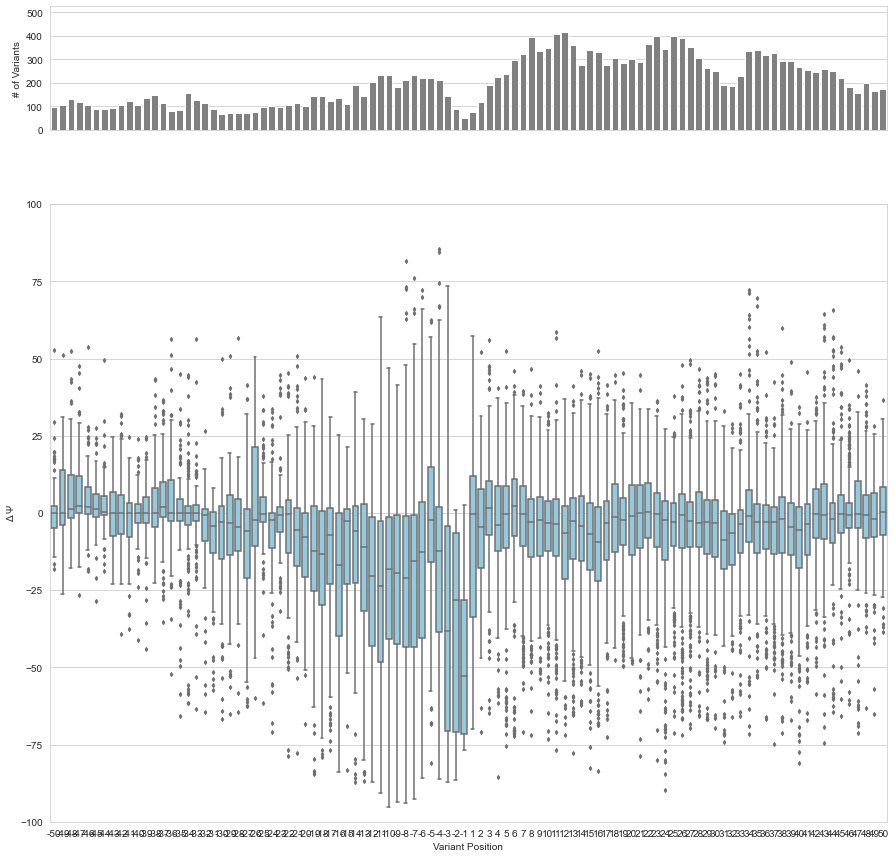

In [10]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5])

def three_prime_SS_plot(delta_df):

    plot_df = delta_df[delta_df.loc[:,'relative_3_prime_SS'] <=50]
    plot_df = plot_df[plot_df.loc[:,'relative_3_prime_SS'] >= -50]
    
    plot_df['average_delta_PSI'] = plot_df.loc[:,('HepG2_delta_psi', 'K562_delta_psi')].mean(axis=1)
    plot_df = plot_df.loc[:,('group_id', 'relative_3_prime_SS', 'average_delta_PSI')].drop_duplicates()
    
    stupid_filler = {'group_id': [], 'relative_3_prime_SS': [], 'average_delta_PSI': []}
    seen_locations = set(plot_df.loc[:,'relative_3_prime_SS'])
    for i in range(-50, 51):
        if i not in seen_locations and i != 0:
            stupid_filler['group_id'].append(0)
            stupid_filler['relative_3_prime_SS'].append(i)
            stupid_filler['average_delta_PSI'].append(np.nan)
    plot_df = pd.concat([plot_df, pd.DataFrame(stupid_filler)])
    plot_df['relative_3_prime_SS'] = plot_df.loc[:,'relative_3_prime_SS'].astype(int)
    histax = plt.subplot(gs[0])
    histo_series = plot_df.loc[:,'relative_3_prime_SS'].value_counts().sort_index()
    sns.barplot(histo_series.index, histo_series, color = 'gray', ax = histax)
    histax.set_ylabel('# of Variants')
    histax.set_ylim(0,525)
    plt.setp(histax.get_xticklabels(), visible=False)

    axA = plt.subplot(gs[1])
    sns.boxplot(x="relative_3_prime_SS", y="average_delta_PSI", data = plot_df, fliersize =3, color = 'skyblue', width = 0.7, ax = axA)
    plt.ylabel(u"\u0394 \u03A8"); plt.ylim(-100, 100)
    plt.xlabel("Variant Position")
    return plot_df
    
plot_df = three_prime_SS_plot(delta_PSI_df)

#plt.savefig(figure_out_dir + 'Figure_3A_three_prime_SS_delta_psi_location_SUPPA2.svg')

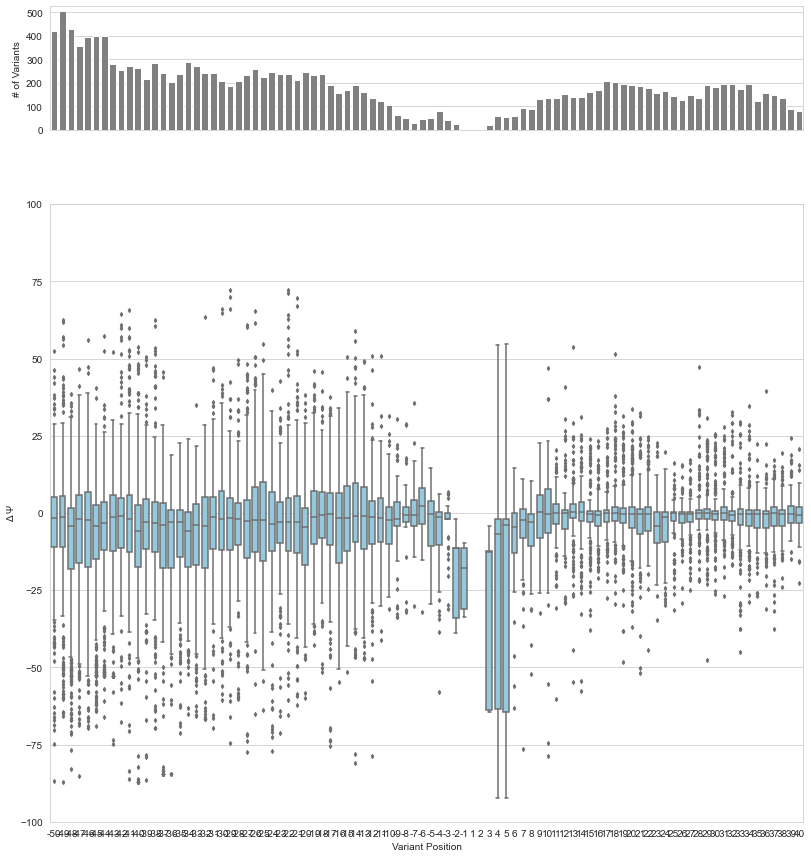

In [11]:
fig = plt.figure(figsize=(13.5,15))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5]) 

def five_prime_SS_plot(delta_df):
    plot_df = delta_df[delta_df.loc[:,'relative_5_prime_SS'] <= 40]
    plot_df = plot_df[plot_df.loc[:,'relative_5_prime_SS'] >= -50]

    plot_df['average_delta_PSI'] = plot_df.loc[:,('HepG2_delta_psi', 'K562_delta_psi')].mean(axis=1)
    plot_df = plot_df.loc[:,('group_id', 'relative_5_prime_SS', 'average_delta_PSI')].drop_duplicates()
    stupid_filler = {'group_id': [], 'relative_5_prime_SS': [], 'average_delta_PSI': []}
    seen_locations = set(plot_df.loc[:,'relative_5_prime_SS'])
    for i in range(-50, 41):
        if i not in seen_locations and i != 0:
            stupid_filler['group_id'].append(0)
            stupid_filler['relative_5_prime_SS'].append(i)
            stupid_filler['average_delta_PSI'].append(np.nan)
    plot_df = pd.concat([plot_df, pd.DataFrame(stupid_filler)])
    
    histax = plt.subplot(gs[0])
    histo_series = plot_df.loc[:,'relative_5_prime_SS'].value_counts().sort_index()
    sns.barplot(histo_series.index, histo_series, color = 'gray', ax = histax)
    
    histax.set_ylabel('# of Variants')
    histax.set_ylim(0,525)
    plt.setp(histax.get_xticklabels(), visible=False)
    
    axA = plt.subplot(gs[1])
    sns.boxplot(x="relative_5_prime_SS", y="average_delta_PSI", data = plot_df, fliersize =3,
                color = 'skyblue', width = 0.7, ax = axA, zorder=1)
    plt.ylabel(u"\u0394 \u03A8"); plt.ylim(-100, 100)
    plt.xlabel("Variant Position")
    return plot_df

plot_df = five_prime_SS_plot(delta_PSI_df)
#plt.savefig(figure_out_dir + 'Figure_3A_five_prime_SS_delta_psi_location_SUPPA2.svg')

In [12]:
#calculating the percentage of |delta_psi| > 20 in regions away from the annotated splice sites
delta_PSI_df['average_delta_PSI'] = delta_PSI_df.loc[:,('HepG2_delta_psi', 'K562_delta_psi')].mean(axis = 1)
upstream_df = delta_PSI_df[delta_PSI_df.loc[:,'relative_3_prime_SS']<20]
downstream_df = delta_PSI_df[delta_PSI_df.loc[:,'relative_5_prime_SS']>20]
exon_df = delta_PSI_df[(delta_PSI_df.loc[:,'relative_3_prime_SS']>0) &
                      (delta_PSI_df.loc[:,'relative_5_prime_SS']<0)]
print(round(upstream_df[upstream_df.loc[:,'average_delta_PSI'] >= 20].shape[0]*100/upstream_df.shape[0], 3))
print(round(exon_df[exon_df.loc[:,'average_delta_PSI'] >= 20].shape[0]*100/exon_df.shape[0], 3))
print(round(downstream_df[downstream_df.loc[:,'average_delta_PSI'] >= 20].shape[0]*100/downstream_df.shape[0], 3))


5.903
5.438
4.267


# Account for statistical significance and unannotated splicing events #

In [13]:
suppa_df = pd.read_csv(base_dir + 'preprocessed_data/' + 'HepG2_suppa_postprocessed.tsv', sep = '\t')
suppa_df['corrected_pval'] = smstats.multitest.multipletests(suppa_df.loc[:,'pval'], method = 'fdr_bh')[1]
suppa_df = suppa_df[suppa_df.loc[:,'delta_psi'].isna() == False]

SE_info = pd.read_csv(base_dir + 'preprocessed_data/suppa_MaxEntScan_info_SE.tsv', sep = '\t')

suppa_df_SE = suppa_df.merge(SE_info, on = ['group_id', 'event_id'])
suppa_df_SE = suppa_df_SE[(suppa_df_SE.loc[:,'event_class'] == 'SE')]

def refine_SS_status_SE(row, SS):
    if row['included_' + SS + 'SS_ref_maxEntScan'] == row['included_' + SS + 'SS_var_maxEntScan']:
        return 'Same'
    else:
        if row['included_' + SS + 'SS_ref_maxEntScan'] > row['included_' + SS + 'SS_var_maxEntScan']:
            if row[SS + 'SS_status'] != 'Same':
                return row[SS + 'SS_status']
            else:
                return 'Weakened'
        else:
            if row[SS + 'SS_status'] != 'Same':
                return row[SS + 'SS_status']
            else:
                return 'Strengthened'
            
suppa_df_SE['3SS_status'] = suppa_df_SE.apply(refine_SS_status_SE, axis = 1, SS = '3')
suppa_df_SE['5SS_status'] = suppa_df_SE.apply(refine_SS_status_SE, axis = 1, SS = '5')
suppa_df_SE = suppa_df_SE[suppa_df_SE.loc[:,'corrected_pval'] <= 0.05]

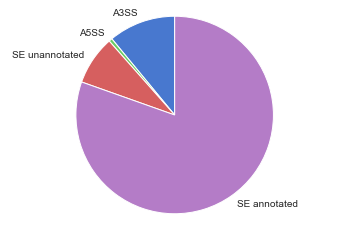

9855

In [14]:
summary_df = suppa_df[suppa_df.loc[:,'corrected_pval'] <= 0.05].groupby(['event_class', 'annotated']).size().reset_index(name='counts')
summary_df

labels = 'A3SS', 'A5SS', 'SE unannotated', 'SE annotated'
sizes = summary_df.loc[:,'counts']


fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, startangle=90)
ax1.axis('equal') 

#plt.savefig(figure_out_dir + 'Figure_3B_splicing_event_pie_chart.svg')
#plt.savefig(figure_out_dir + 'Figure_3B_splicing_event_pie_chart.png')

plt.show()

summary_df.loc[:,'counts'].sum()



{27200, 19490, 1987, 4123, 3817, None, 15217, 7483}


Text(0.5, 0, 'Annotated exon')

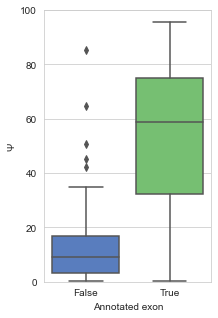

In [15]:
plot_df = suppa_df[(suppa_df.loc[:,'group_id'] == suppa_df.loc[:,'reference_id']) & (suppa_df.loc[:,'event_class'] == 'SE')]
keeper_ids = set(plot_df[plot_df.loc[:,'annotated'] == False].loc[:,'group_id'])
plot_df = plot_df[plot_df.loc[:,'group_id'].isin(keeper_ids)]

group_ids = set(plot_df.loc[:,'group_id'])

def novel_greater(group_id, df):
    this_df = df[df.loc[:,'group_id'] == group_id]
    if this_df[this_df.loc[:,'annotated'] == True].shape[0] !=0:
        annotated_PSI = list(set(this_df[this_df.loc[:,'annotated'] == True].loc[:,'ref_psi']))[0]
        unannotated_PSIs = set(this_df[this_df.loc[:,'annotated'] == False].loc[:,'ref_psi'])
        for PSI in unannotated_PSIs:
            if PSI >= annotated_PSI:
                return group_id
    else:
        return group_id

novel_dominant = set()
for group_id in group_ids:
    novel_dominant.add(novel_greater(group_id, plot_df))
print(novel_dominant)

fig, ax = plt.subplots(1,1, figsize = (3,5))
sns.boxplot(x = 'annotated', y ='ref_psi', data = plot_df, ax = ax)
plt.ylim(0,100)
plt.ylabel('\u03A8')
plt.xlabel("Annotated exon")
#plt.savefig(figure_out_dir + 'Supplemental_Figure_3A_HepG2_reference_SEs.svg')

73
{27200, 19490, 1987, 4123, 3817, None, 15217, 32472, 7483}


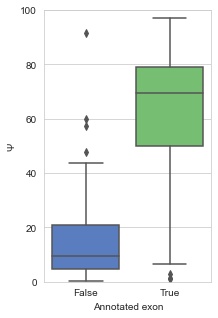

In [16]:
suppa_df_K562 = pd.read_csv(base_dir + 'preprocessed_data/' + 'K562_suppa_postprocessed.tsv', sep = '\t')
suppa_df_K562['corrected_pval'] = smstats.multitest.multipletests(suppa_df_K562.loc[:,'pval'], method = 'fdr_bh')[1]
suppa_df_K562 = suppa_df_K562[suppa_df_K562.loc[:,'delta_psi'].isna() == False]
suppa_df_K562_SE = suppa_df_K562.merge(SE_info, on = ['group_id', 'event_id'])
suppa_df_K562_SE = suppa_df_K562_SE[(suppa_df_K562_SE.loc[:,'event_class'] == 'SE')]

plot_df = suppa_df_K562_SE[(suppa_df_K562_SE.loc[:,'group_id'] == suppa_df_K562_SE.loc[:,'reference_id'])]
keeper_ids = set(plot_df[plot_df.loc[:,'annotated'] == False].loc[:,'group_id'])
plot_df = plot_df[plot_df.loc[:,'group_id'].isin(keeper_ids)]

K562_group_ids = set(plot_df.loc[:,'group_id'])

novel_dominant = set()
for group_id in K562_group_ids:
    novel_dominant.add(novel_greater(group_id, plot_df))
print(len(K562_group_ids.union(group_ids)))
print(novel_dominant)

fig, ax = plt.subplots(1,1, figsize = (3,5))
sns.boxplot(x = 'annotated', y ='ref_psi', data = plot_df, ax = ax)
plt.ylabel('\u03A8')
plt.ylim(0,100)
plt.xlabel("Annotated exon")
#plt.savefig(figure_out_dir + 'Supplemental_Figure_3B_K562_reference_SEs.svg')
suppa_df_K562_SE = None; suppa_df_K562 = None

Text(0.5, 0, "3' splice site status")

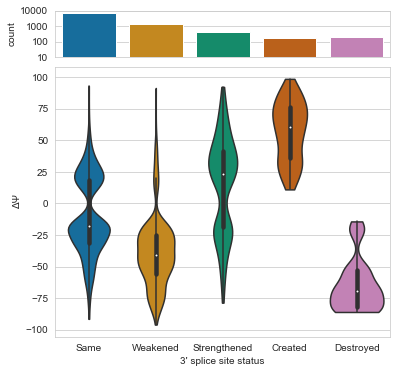

In [17]:
fig = plt.figure(1, figsize=(6,6))
gs = gridspec.GridSpec(6,5)

SS_categories = ['Same', 'Weakened', 'Strengthened', 'Created', 'Destroyed', 'GT/GC_switch']
this_palette = sns.color_palette("colorblind", 6)

plt.subplot2grid((6,5), (0,0), rowspan = 1, colspan = 5)

this_plot = suppa_df_SE[(suppa_df_SE.loc[:,'3SS_status'] != 'Other_non-canonical')]
sns.countplot(this_plot.loc[:,'3SS_status'], order = SS_categories[0:5], palette = this_palette[0:5])

plt.gca().set_yscale('log')
plt.gca().set_yticks([10, 100, 1000, 10000])
plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

locs, labels = plt.xticks() 
plt.xticks(locs, labels = ['']*5)
plt.subplot2grid((6,5), (1,0),rowspan = 5, colspan = 5)
sns.violinplot(x = '3SS_status', y = 'delta_psi', data = this_plot,
               cut =0, order = SS_categories[0:5], palette = this_palette[0:5])

plt.ylabel('\u0394\u03A8')
plt.xlabel("3' splice site status")
#plt.savefig(figure_out_dir + 'Figure_3C_SE_three_prime_violin.svg')
#plt.savefig(figure_out_dir + 'Figure_3C_SE_three_prime_violin.png')



Text(0.5, 0, "5' splice site status")

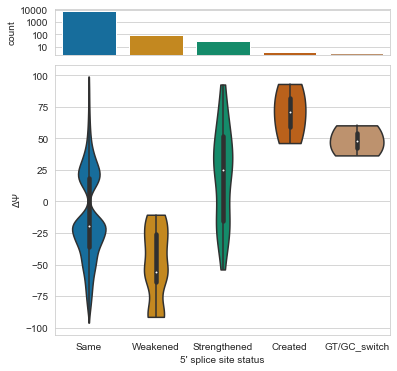

In [18]:
fig = plt.figure(1, figsize=(6,6))
gs = gridspec.GridSpec(6,5)

plt.subplot2grid((6,5), (0,0), rowspan = 1, colspan = 5)
sns.countplot(suppa_df_SE.loc[:,'5SS_status'], order =SS_categories[0:4] + [SS_categories[5]],
              palette = this_palette[0:4] + [this_palette[5]])

plt.gca().set_yscale('log')
plt.gca().set_yticks([10, 100, 1000, 10000])
plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

locs, labels = plt.xticks() 
plt.xticks(locs, labels = ['']*5)

plt.subplot2grid((6,5), (1,0),rowspan = 5, colspan = 5)
sns.violinplot(x = '5SS_status', y = 'delta_psi', data = suppa_df_SE, cut =0,
               order =SS_categories[0:4] + [SS_categories[5]],
               palette = this_palette[0:4] + [this_palette[5]])

plt.ylabel('\u0394\u03A8')
plt.xlabel("5' splice site status")

#plt.savefig(figure_out_dir + 'Figure_3D_SE_five_prime_violin.svg')
#plt.savefig(figure_out_dir + 'Figure_3D_SE_five_prime_violin.png')



Text(0.5, 0, "Long exon 3' splice site status")

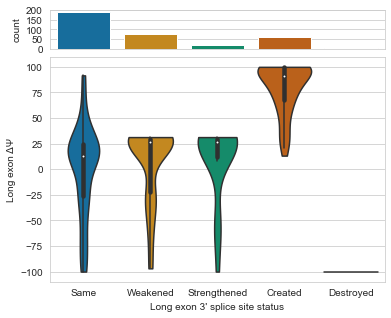

In [19]:
Athree_info = pd.read_csv(base_dir + 'preprocessed_data/' + 'suppa_MaxEntScan_info_A3.tsv', sep = '\t')

suppa_df_A3 = suppa_df.merge(Athree_info, on = ['group_id', 'event_id'])
suppa_df_A3 = suppa_df_A3[(suppa_df_A3.loc[:,'event_class'] == 'A3')]

def refine_SS_status_A35(row, SS):
    if row[SS + 'SS_ref_maxEntScan'] == row[SS + 'SS_var_maxEntScan']:
        return 'Same'
    else:
        if row[SS + 'SS_ref_maxEntScan'] > row[SS + 'SS_var_maxEntScan']:
            if row[SS + 'SS_status'] != 'Same':
                return row[SS + 'SS_status']
            else:
                return 'Weakened'
        else:
            if row[SS + 'SS_status'] != 'Same':
                return row[SS + 'SS_status']
            else:
                return 'Strengthened'
suppa_df_A3['long_3SS_status'] = suppa_df_A3.apply(refine_SS_status_A35, axis = 1, SS = 'long_3')
suppa_df_A3['short_3SS_status'] = suppa_df_A3.apply(refine_SS_status_A35, axis = 1, SS = 'short_3')
suppa_df_A3 = suppa_df_A3[suppa_df_A3.loc[:,'corrected_pval'] <= 0.05]

this_plot = suppa_df_A3[suppa_df_A3.loc[:,'short_3SS_status'] == 'Same']

fig = plt.figure(1, figsize=(6,5))
gs = gridspec.GridSpec(6,5)
plt.subplot2grid((6,5), (0,0), rowspan = 1, colspan = 5)

sns.countplot(this_plot.loc[:,'long_3SS_status'], order = SS_categories[0:5], palette = this_palette[0:5])
plt.gca().set_yticks([0,50,100,150,200])

locs, labels = plt.xticks() 
plt.xticks(locs, labels = ['']*5)
plt.subplot2grid((6,5), (1,0),rowspan = 5, colspan = 5)
sns.violinplot(x = 'long_3SS_status', y = 'delta_psi', data = this_plot, cut =0, order = SS_categories[0:5],
               palette = this_palette[0:5])
plt.ylabel('Long exon \u0394\u03A8')
plt.xlabel("Long exon 3' splice site status")

#plt.savefig(figure_out_dir + 'Figure_3E_A3_long_SS_violin.svg')
#plt.savefig(figure_out_dir + 'Figure_3E_A3_long_SS_violin.png')

Text(0.5, 0, "Short exon 3' splice site status")

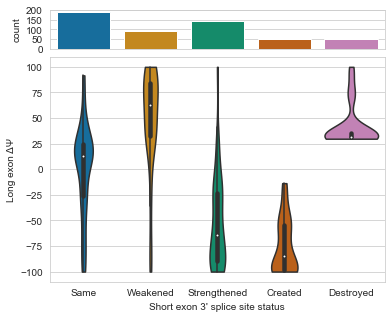

In [20]:
fig = plt.figure(1, figsize=(6,5))
gs = gridspec.GridSpec(6,5)

this_plot = suppa_df_A3[suppa_df_A3.loc[:,'long_3SS_status'] == 'Same']

plt.subplot2grid((6,5), (0,0), rowspan = 1, colspan = 5)
sns.countplot(this_plot.loc[:,'short_3SS_status'], order = SS_categories[0:5], palette = this_palette[0:5])
plt.gca().set_yticks([0,50,100,150,200])

locs, labels = plt.xticks() 
plt.xticks(locs, labels = ['']*5)
plt.subplot2grid((6,5), (1,0),rowspan = 5, colspan = 5)
sns.violinplot(x = 'short_3SS_status', y = 'delta_psi', data = this_plot, cut =0, order = SS_categories[0:5],
               palette = this_palette[0:5])
plt.ylabel('Long exon \u0394\u03A8')
plt.xlabel("Short exon 3' splice site status")

#plt.savefig(figure_out_dir + 'Figure_3F_A3_short_SS_violin.svg')
#plt.savefig(figure_out_dir + 'Figure_3F_A3_short_SS_violin.png')

In [21]:
#variants which change the short 3'SS status tend to change splicing more than those that change the long 3'SS status
print(stats.fisher_exact([[suppa_df_A3[suppa_df_A3.loc[:,'short_3SS_status'] != 'Same'].shape[0],
                    suppa_df_A3[suppa_df_A3.loc[:,'short_3SS_status'] == 'Same'].shape[0]],
                   [suppa_df_A3[suppa_df_A3.loc[:,'long_3SS_status'] != 'Same'].shape[0],
                    suppa_df_A3[suppa_df_A3.loc[:,'long_3SS_status'] == 'Same'].shape[0]]]))
print(stats.fisher_exact([[suppa_df_A3[(suppa_df_A3.loc[:,'short_3SS_status'] != 'Same') & (suppa_df_A3.loc[:,'long_3SS_status'] == 'Same')].shape[0],
                    suppa_df_A3[(suppa_df_A3.loc[:,'short_3SS_status'] == 'Same') & (suppa_df_A3.loc[:,'long_3SS_status'] == 'Same')].shape[0]],
                   [suppa_df_A3[(suppa_df_A3.loc[:,'long_3SS_status'] != 'Same' ) & (suppa_df_A3.loc[:,'short_3SS_status'] == 'Same')].shape[0],
                    suppa_df_A3[(suppa_df_A3.loc[:,'long_3SS_status'] == 'Same') & (suppa_df_A3.loc[:,'short_3SS_status'] == 'Same')].shape[0]]]))
print(suppa_df_A3[(suppa_df_A3.loc[:,'long_3SS_status'] != 'Same' ) & (suppa_df_A3.loc[:,'short_3SS_status'] != 'Same')].shape[0])

(1.994882154882155, 7.61322733051855e-15)
(2.0987654320987654, 1.1961917226392702e-07)
388


Text(0.5, 0, "Long exon 5' splice site status")

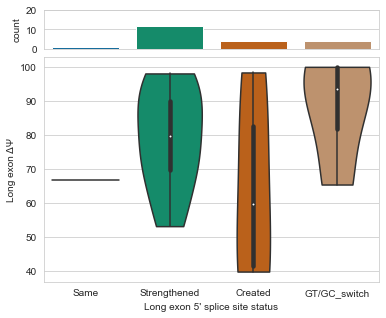

In [22]:
Afive_info = pd.read_csv(base_dir + 'preprocessed_data/' + 'suppa_MaxEntScan_info_A5.tsv', sep = '\t')

suppa_df_A5 = suppa_df.merge(Afive_info, on = ['group_id', 'event_id'])
suppa_df_A5 = suppa_df_A5[(suppa_df_A5.loc[:,'event_class'] == 'A5')]

suppa_df_A5['long_5SS_status'] = suppa_df_A5.apply(refine_SS_status_A35, axis = 1, SS = 'long_5')
suppa_df_A5['short_5SS_status'] = suppa_df_A5.apply(refine_SS_status_A35, axis = 1, SS = 'short_5')
suppa_df_A5 = suppa_df_A5[suppa_df_A5.loc[:,'corrected_pval'] <= 0.05]

fig = plt.figure(1, figsize=(6,5))
gs = gridspec.GridSpec(6,5)

plt.subplot2grid((6,5), (0,0), rowspan = 1, colspan = 5)
this_plot = suppa_df_A5[suppa_df_A5.loc[:,'short_5SS_status'] == 'Same']
sns.countplot(this_plot.loc[:,'long_5SS_status'], order = SS_categories[0:1] + SS_categories[2:4] + SS_categories[5:6],
              palette = this_palette[0:1] + this_palette[2:4] + this_palette[5:6])
plt.gca().set_yticks([0,10,20])

locs, labels = plt.xticks() 
plt.xticks(locs, labels = ['']*4)
plt.subplot2grid((6,5), (1,0),rowspan = 5, colspan = 5)
sns.violinplot(x = 'long_5SS_status', y = 'delta_psi', data = this_plot, cut =0, 
               order = SS_categories[0:1] + SS_categories[2:4] + SS_categories[5:6],
               palette = this_palette[0:1] + this_palette[2:4] + this_palette[5:6])
plt.ylabel('Long exon \u0394\u03A8')
plt.xlabel("Long exon 5' splice site status")

#plt.savefig(figure_out_dir + 'Supplemental_Figure_4A_A5_long_SS_violin.svg')

Text(0.5, 0, "Short exon 5' splice site status")

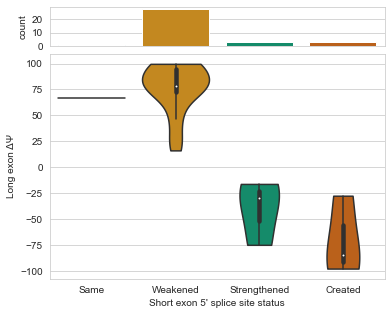

In [23]:
fig = plt.figure(1, figsize=(6,5))
gs = gridspec.GridSpec(6,5)

plt.subplot2grid((6,5), (0,0), rowspan = 1, colspan = 5)

this_plot = suppa_df_A5[suppa_df_A5.loc[:,'long_5SS_status'] == 'Same']

sns.countplot(this_plot.loc[:,'short_5SS_status'], order = SS_categories[0:4], palette = this_palette[0:4])
plt.gca().set_yticks([0,10,20])
locs, labels = plt.xticks() 
plt.xticks(locs, labels = ['']*4)


plt.subplot2grid((6,5), (1,0),rowspan = 5, colspan = 5)
sns.violinplot(x = 'short_5SS_status', y = 'delta_psi', data = this_plot, cut =0,
               order = SS_categories[0:4], palette = this_palette[0:4])
plt.ylabel('Long exon \u0394\u03A8')
plt.xlabel("Short exon 5' splice site status")

#plt.savefig(figure_out_dir + 'Supplemental_Figure_4B_A5_short_SS_violin.svg')

# kmer motif analysis #

In [24]:
seqs = {}
a = open(base_dir + 'preprocessed_data/' + 'all_seqs.fa', 'r') 
for line in a:
    line= line.replace('\n', '')
    if line[0] == '>':
        group_id = line.replace('>', '')
    else:
        seqs[group_id] = line[2:]
a.close()

def variant_position(row, window):
    variant = str(row['group_id'])
    variant_seq = seqs[variant]
    reference_seq = seqs[str(row['reference_id'])]
    different = []
    for i in range(0, len(variant_seq)):
        if variant_seq[i] != reference_seq[i]:
            different.append(i) 
    if different == []:
        return np.nan, np.nan
    else:
        return min(different) - window, max(different) + window + 1

    
suppa_df = pd.read_csv(base_dir + 'preprocessed_data/' + 'HepG2_suppa_postprocessed.tsv', sep = '\t')
suppa_df['corrected_pval'] = smstats.multitest.multipletests(suppa_df.loc[:,'pval'], method = 'fdr_bh')[1]
suppa_df = suppa_df[suppa_df.loc[:,'delta_psi'].isna() == False]

SE_info = pd.read_csv(base_dir + 'preprocessed_data/' + 'suppa_MaxEntScan_info_SE.tsv', sep = '\t')

suppa_df_SE = suppa_df.merge(SE_info, on = ['group_id', 'event_id'])
suppa_df_SE = suppa_df_SE[(suppa_df_SE.loc[:,'event_class'] == 'SE')]
    

sequence_design_info = pd.read_csv(base_dir + 'preprocessed_data/' + 'SRE_pool_sequences_dups_hg19.tsv', sep = '\t')
keeper_cols = ('chromosome', 'position', 'reference', 'alternative', 'intron_lower', 'intron_upper', 'exon_start',
              'exon_end', 'strand', 'control', 'group_id')
sequence_design_info = sequence_design_info.loc[:,keeper_cols].drop_duplicates()
sequence_design_info = sequence_design_info.groupby(by = ['control', 'group_id']).first().reset_index().loc[:,('control', 'reference', 'alternative', 'position', 'group_id', 'strand')]

suppa_df_SE[['variant_position_min', 'variant_position_max']] = suppa_df_SE.apply(variant_position, axis = 1, result_type = "expand", window = 4)
suppa_df_SE = sequence_design_info.merge(suppa_df_SE, on = 'group_id')
suppa_df_SE = suppa_df_SE[suppa_df_SE.loc[:,'variant_position_max'].isna() == False]
suppa_df_SE['RBP_source'] = suppa_df_SE.loc[:,'control'].str.split('|').str[0]
#suppa_df_SE = suppa_df_SE[(suppa_df_SE.loc[:,'3SS_status'] == 'Same') & (suppa_df_SE.loc[:,'5SS_status'] == 'Same')]

info_dir = ''
chunk_df = pd.read_csv(base_dir + 'preprocessed_data/' + 'group_id_to_chunk.tsv', sep = '\t')
chunk_dict = dict(zip(chunk_df.loc[:,'group_id'], chunk_df.loc[:,'chunk_id']))

def unify_event_id(event_id):
    #143;SE:143:44-225:305-1004:+
    ref_id = var2ref[event_id.split(';')[0]]
    new_event_id = ref_id + ';SE:' + ref_id + ':' + ':'.join(event_id.split(':')[2:])
    return new_event_id

var2ref = {}
a = open(base_dir + 'preprocessed_data/' +'ref2var.tsv', 'r')
reader = csv.reader(a, delimiter ='\t')
for line in reader:
    for var in line[1].split(','):
        var2ref[var] = line[0]
    var2ref[line[0]] = line[0]
a.close()
suppa_df_SE['chunk_id'] = suppa_df_SE.loc[:,'group_id'].map(chunk_dict)

suppa_df_SE['unified_event_id'] = suppa_df_SE.loc[:,'event_id'].apply(unify_event_id)

suppa_df_SE['chunk_id'] = suppa_df_SE.loc[:,'group_id'].map(chunk_dict)
suppa_df = None
suppa_df_SE.head()

,control,reference,alternative,position,group_id,strand_x,reference_id,event_id,event_class,included_transcript_id,...,included_3SS_var_maxEntScan,included_5SS_ref_maxEntScan,included_5SS_var_maxEntScan,3SS_status,5SS_status,variant_position_min,variant_position_max,RBP_source,chunk_id,unified_event_id
0,AKAP8L_K562|22255_SE,CC,CT,1011230,12,-,21552,12;SE:12:44-206:305-1004:+,SE,12_included,...,9.04,10.07,10.07,Same,Same,164.0,173.0,AKAP8L_K562,243,21552;SE:21552:44-206:305-1004:+
1,AKAP8L_K562|22255_SE,CC,CA,1011230,76,-,21552,76;SE:76:44-206:305-1004:+,SE,76_included,...,9.04,10.07,10.07,Same,Same,164.0,173.0,AKAP8L_K562,243,21552;SE:21552:44-206:305-1004:+
2,AKAP8L_K562|22255_SE,TG,TT,1011237,97,-,21552,97;SE:97:44-206:305-1004:+,SE,97_included,...,9.04,10.07,10.07,Same,Same,157.0,166.0,AKAP8L_K562,243,21552;SE:21552:44-206:305-1004:+
3,AKAP8L_K562|22255_SE,CC,AA,1011235,121,-,21552,121;SE:121:44-206:305-1004:+,SE,121_included,...,9.04,10.07,10.07,Same,Same,159.0,169.0,AKAP8L_K562,243,21552;SE:21552:44-206:305-1004:+
4,AKAP8L_K562|22255_SE,GT,CA,1011228,167,-,21552,167;SE:167:44-206:305-1004:+,SE,167_included,...,9.04,10.07,10.07,Same,Same,166.0,176.0,AKAP8L_K562,243,21552;SE:21552:44-206:305-1004:+


In [25]:
def count_kmers(row, k, dict_, dict_type, variant):
    #2807;SE:2807:44-209:301-1004:+
    event_type = row['event_id'].split(';')[1].split(':')[0]
    if event_type == 'SE':
        three_prime_SS = int(row['event_id'].split(':')[2].split('-')[1])
        five_prime_SS = int(row['event_id'].split(':')[3].split('-')[0])
    if variant == 'variant':
        seq = seqs[str(row['group_id'])][int(row['variant_position_min']):int(row['variant_position_max'])]
    elif variant == 'reference':
        seq = seqs[str(row['reference_id'])][int(row['variant_position_min']):int(row['variant_position_max'])]
    if dict_type == 'splice':
        increment = row['delta_psi']
    elif dict_type == 'count':
        increment = 1
    for i in range(0,len(seq)-k +1):
        kmer_center = int(row['variant_position_min']) + i + (k/2)
        if kmer_center < three_prime_SS:
            location = 'upstream'
        else:
            if kmer_center < five_prime_SS:
                location = 'exon'
            else:
                location = 'downstream'
        this_kmer = seq[i:i+k]
        dict_[location][this_kmer] += increment
    return dict_

control_groups = set(suppa_df_SE.loc[:,'control'])
variant_location = {}

variant_kmer_dicts = defaultdict(dict)
reference_kmer_dicts = defaultdict(dict)
for event_id in list(control_groups):
    RBP_source = event_id.split('|')[0]
    this_df = suppa_df_SE[suppa_df_SE.loc[:,'control'] == event_id]
    variant_kmer_dict = {}
    reference_kmer_dict = {}
    for location in ['upstream', 'exon', 'downstream']:
        variant_kmer_dict[location] = defaultdict(lambda:0)
        reference_kmer_dict[location] = defaultdict(lambda:0)
    variant_kmer_dict = this_df.apply(count_kmers, axis = 1, k = 5, dict_ = variant_kmer_dict, dict_type = 'splice', variant = 'variant')
    reference_kmer_dict = this_df.apply(count_kmers, axis = 1, k = 5, dict_ = reference_kmer_dict, dict_type = 'splice', variant = 'reference') 
    variant_kmer_dict = variant_kmer_dict[variant_kmer_dict.index[0]]
    reference_kmer_dict = reference_kmer_dict[reference_kmer_dict.index[0]]
    variant_kmer_dicts[RBP_source][event_id] = variant_kmer_dict
    reference_kmer_dicts[RBP_source][event_id] = reference_kmer_dict 
    
#suppa_df_SE

In [26]:
def kmer_to_events(row, k, dict_, variant):
    #2807;SE:2807:44-209:301-1004:+
    event_type = row['event_id'].split(';')[1].split(':')[0]
    if event_type == 'SE':
        three_prime_SS = int(row['event_id'].split(':')[2].split('-')[1])
        five_prime_SS = int(row['event_id'].split(':')[3].split('-')[0])
    if variant == 'variant':
        seq = seqs[str(row['group_id'])][int(row['variant_position_min']):int(row['variant_position_max'])]
    elif variant == 'reference':
        seq = seqs[str(row['reference_id'])][int(row['variant_position_min']):int(row['variant_position_max'])]
    for i in range(0,len(seq)-k+1):
        kmer_center = int(row['variant_position_min']) + i + (k/2)
        if kmer_center < three_prime_SS:
            location = 'upstream'
        else:
            if kmer_center < five_prime_SS:
                location = 'exon'
            else:
                location = 'downstream'
        this_kmer = seq[i:i+k]
        dict_[location][this_kmer].add(row['event_id'])
    return dict_

control_groups = set(suppa_df_SE.loc[:,'control'])

matched_kmer_dpsis = {}
for location in ['upstream', 'exon', 'downstream']:
    matched_kmer_dpsis[location] = defaultdict(lambda: dict(zip(['with', 'without'], [[],[]])))

i = 0
for event_id in list(control_groups):
    progress_bar(i, len(control_groups))
    RBP_source = event_id.split('|')[0]
    this_df = suppa_df_SE[suppa_df_SE.loc[:,'control'] == event_id]
    this_df = this_df[(this_df.loc[:,'3SS_status'] == 'Same') & 
                     (this_df.loc[:,'5SS_status'] == 'Same')]
    this_kmer_to_event_variant = {}; this_kmer_to_event_reference = {}
    for location in ['upstream', 'exon', 'downstream']:
        this_kmer_to_event_variant[location] = defaultdict(set)
    for row in this_df.iterrows():
        this_kmer_to_event_variant = kmer_to_events(row[1], k = 5, dict_ = this_kmer_to_event_variant, variant = 'variant')
    for location in ['upstream', 'exon', 'downstream']:
        for kmer in this_kmer_to_event_variant[location]:
            with_df = this_df[this_df.loc[:,'event_id'].isin(this_kmer_to_event_variant[location][kmer])]
            without_df = this_df[this_df.loc[:,'event_id'].isin(this_kmer_to_event_variant[location][kmer]) == False]
            matched_kmer_dpsis[location][kmer]['with'] += list(with_df.loc[:,'delta_psi'])
            matched_kmer_dpsis[location][kmer]['without'] += list(without_df.loc[:,'delta_psi'])

    i+=1


[====================] 100%

In [27]:
bases = ['A', 'C', 'G', 'T']
kmers = [''.join(p) for p in itertools.product(bases, repeat=5)]
CLES_dict = {}
pval_dict = {}
kmer_counts_with = {}
for region in ['upstream', 'downstream', 'exon']:
    pval_dict[region] = {}
    CLES_dict[region] = {}
    kmer_counts_with[region] = []
    for kmer in kmers:
        mwu = stats.mannwhitneyu(x = matched_kmer_dpsis[region][kmer]['with'],
                                 y = matched_kmer_dpsis[region][kmer]['without'], alternative = 'two-sided')
        kmer_counts_with[region].append(len(matched_kmer_dpsis[region][kmer]['with']))
        pval = mwu.pvalue
        pval_dict[region][kmer] = pval
        CLES = mwu[0]/(len(matched_kmer_dpsis[region][kmer]['with'])*len(matched_kmer_dpsis[region][kmer]['without']))
        CLES_dict[region][kmer] = CLES
pval_df = pd.DataFrame({'upstream_pval': pval_dict['upstream'], 'downstream_pval': pval_dict['downstream'], 'exon_pval': pval_dict['exon'],
                       'upstream_CLES': CLES_dict['upstream'], 'downstream_CLES': CLES_dict['downstream'], 'exon_CLES': CLES_dict['exon']})
pval_df['exon_BH'] = smstats.multitest.multipletests(pval_df.loc[:,'exon_pval'], method = 'fdr_bh')[1]
pval_df['upstream_BH'] = smstats.multitest.multipletests(pval_df.loc[:,'upstream_pval'], method = 'fdr_bh')[1]
pval_df['downstream_BH'] = smstats.multitest.multipletests(pval_df.loc[:,'downstream_pval'], method = 'fdr_bh')[1]

pval_df.sort_values('downstream_pval').head()

,upstream_pval,downstream_pval,exon_pval,upstream_CLES,downstream_CLES,exon_CLES,exon_BH,upstream_BH,downstream_BH
GTTTT,0.947217,9.759190e-09,2.783681e-03,0.501151,0.331784,0.440909,9.077990e-03,0.983722,0.000010
CCAGG,0.000129,3.746925e-06,1.681274e-01,0.635637,0.311764,0.474670,2.571161e-01,0.002541,0.001918
GGGGA,0.939949,6.373220e-06,1.141654e-05,0.503196,0.710288,0.424650,8.724279e-05,0.981796,0.002175
GGTTT,0.066545,1.497507e-05,1.968053e-01,0.458243,0.338776,0.467211,2.908061e-01,0.242625,0.003834
TGGGG,0.898460,3.089007e-05,6.841248e-12,0.504992,0.666105,0.375389,3.502719e-10,0.972540,0.005081


248
16597


upstream_pval      5.218336e-02
downstream_pval    7.714675e-01
exon_pval          1.250767e-08
upstream_CLES      5.796757e-01
downstream_CLES    4.888109e-01
exon_CLES          3.948688e-01
exon_BH            2.613848e-07
upstream_BH        2.103770e-01
downstream_BH      9.245251e-01
Name: AGGGA, dtype: float64

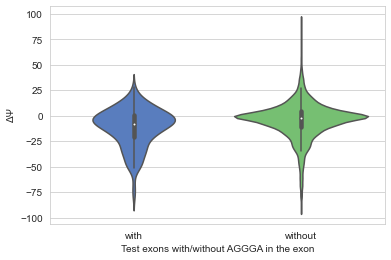

In [28]:
#univariate example of AGGGA, part of HNRNPA1 motif
kmer = 'AGGGA'

delta_psis = matched_kmer_dpsis['exon'][kmer]['with'] + matched_kmer_dpsis['exon'][kmer]['without']
plot_df = pd.DataFrame({kmer:['with'] * len(matched_kmer_dpsis['exon'][kmer]['with']) + ['without']*len(matched_kmer_dpsis['exon'][kmer]['without']),
                       'delta_psi': delta_psis})
sns.violinplot(x = kmer, y = 'delta_psi', data = plot_df)
plt.ylabel(u'\u0394\u03A8')
plt.xlabel('Test exons with/without ' + kmer.replace('T','U') + ' in the exon')
print(len(matched_kmer_dpsis['exon'][kmer]['with']))
print(len(matched_kmer_dpsis['exon'][kmer]['without']))

pval_df.loc[kmer]

131.0
50.0
36.0


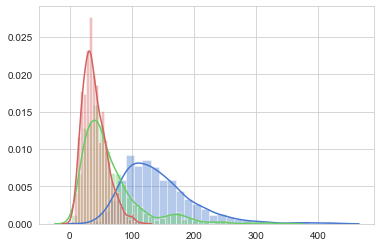

In [29]:
#stats for number of delta psi measurements per kmer
sns.distplot(kmer_counts_with['exon'])
sns.distplot(kmer_counts_with['upstream'])
sns.distplot(kmer_counts_with['downstream'])
print(np.median(kmer_counts_with['exon']))
print(np.median(kmer_counts_with['upstream']))
print(np.median(kmer_counts_with['downstream']))

Any significant 534
Upstream significant 137
Exon significant 454
Downstream significant 14


[None, None, None, None, None, None]

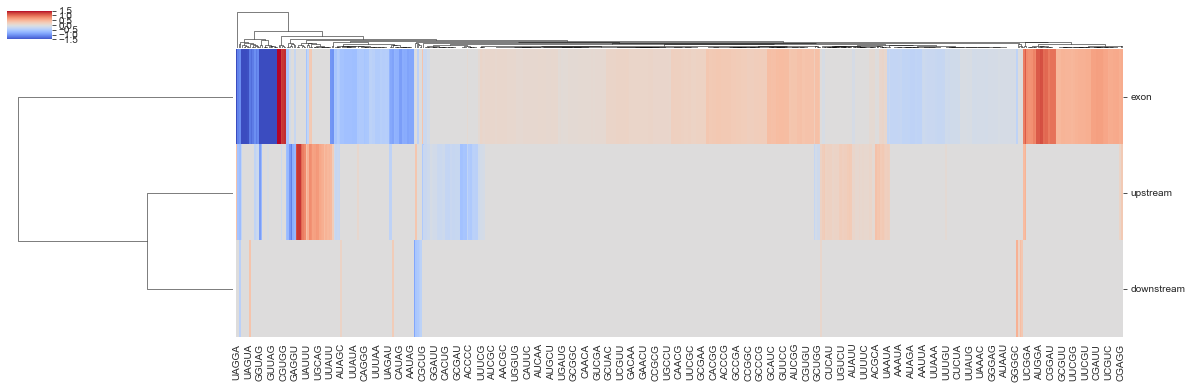

In [30]:
def clip_NS(row, corrected_p):
    for region in ['upstream', 'downstream', 'exon']:
        if row[region + '_BH'] > corrected_p:
            row[region + '_CLES'] = 0.5
    return row

plot_df = pval_df.copy()
plot_df = plot_df.apply(clip_NS, axis = 1, corrected_p = 0.05)

print('Any significant', plot_df[(plot_df.loc[:,'exon_BH'] <=0.05) | (plot_df.loc[:,'upstream_BH'] <=0.05) | (plot_df.loc[:,'downstream_BH'] <=0.05)].shape[0])
print('Upstream significant', plot_df[(plot_df.loc[:,'upstream_BH'] <=0.05)].shape[0])
print('Exon significant', plot_df[(plot_df.loc[:,'exon_BH'] <=0.05)].shape[0])
print('Downstream significant', plot_df[(plot_df.loc[:,'downstream_BH'] <=0.05)].shape[0])

for region in ['upstream', 'downstream', 'exon']:
    plot_df[region+ '_sig_weighted_CLES'] = -np.log10(plot_df.loc[:,region + '_BH']) * (plot_df.loc[:,region + '_CLES']-0.5)
plot_df = plot_df.loc[:,('exon_sig_weighted_CLES', 'upstream_sig_weighted_CLES', 'downstream_sig_weighted_CLES')].fillna(0)
plot_df.columns = ['exon', 'upstream', 'downstream']
plot_df = plot_df[plot_df.sum(axis=1) !=0]
plot_df.index = plot_df.index.str.replace('T', 'U')
g = sns.clustermap(plot_df.transpose(), figsize=(20, 6), cmap="coolwarm", vmin = -1.5, vmax = 1.5)
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
#plt.savefig(figure_out_dir + 'Figure_4A_kmer_heatmap.svg')
#plt.savefig(figure_out_dir + 'Figure_4A_kmer_heatmap.png')

In [31]:
#reformatted from ESEseq qunatifications in Ke et al., Genome Res. 2011 https://dx.doi.org/10.1101%2Fgr.119628.110
ESEseq_df = pd.read_csv(base_dir + 'preprocessed_data/'+ 'ESEseq_simple.tsv', sep = '\t')
def hexamer_to_pentamer(hexamer):
    pentamerA = hexamer[0:5]
    pentamerB = hexamer[1:]
    return set([pentamerA, pentamerB])

ESEseq_scores = dict(zip(ESEseq_df.loc[:,'hexamer'], ESEseq_df.loc[:,'ESEseq_score']))
average_penta_scores = []
for hexamer in sorted(list(set(ESEseq_df.loc[:,'hexamer']))):
    penta_scores = []
    for pentamer in hexamer_to_pentamer(hexamer):
        penta_scores.append(pval_df.loc[pentamer]['exon_CLES'])
    average_penta_scores.append(np.mean(penta_scores))
output_df = pd.DataFrame({'hexamer': sorted(list(set(ESEseq_df.loc[:,'hexamer']))), 'our_score': average_penta_scores})
output_df['ESEseq_score'] = output_df.loc[:,'hexamer'].map(ESEseq_scores)
output_df.head()

,hexamer,our_score,ESEseq_score
0,AAAAAA,0.441466,0.000000
1,AAAAAC,0.462343,0.000000
2,AAAAAG,0.461965,0.000000
3,AAAAAT,0.457886,-0.342638
4,AAAACA,0.510276,0.000000


SpearmanrResult(correlation=0.6594988282336122, pvalue=0.0)


(-1.1, 1.1)

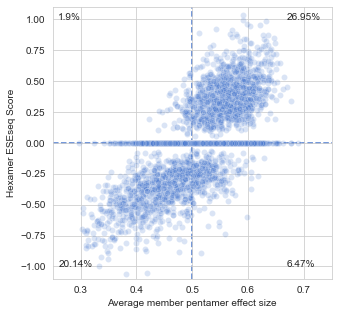

In [32]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
sns.set_style("whitegrid")
sns.scatterplot(x = 'our_score', y = 'ESEseq_score', data = output_df, alpha = 0.2, ax = ax)
print(stats.spearmanr(output_df.loc[:,'our_score'], output_df.loc[:,'ESEseq_score']))
plt.ylabel('Hexamer ESEseq Score')
plt.xlabel('Average member pentamer effect size')

ax.hlines(0, xmin = 0.25, xmax = 0.75, linestyles ='dashed', zorder = 0)
ax.vlines(0.5, ymin = -1.1, ymax = 1.1, linestyles ='dashed', zorder = 0)

ax.text(0.26, -1, s = str(round(output_df[(output_df.loc[:,'ESEseq_score']< 0) &
                                   (output_df.loc[:,'our_score']< 0.5)].shape[0]*100/ output_df.shape[0], 2)) + '%')
ax.text(0.26, 1, s = str(round(output_df[(output_df.loc[:,'ESEseq_score']> 0) &
                                   (output_df.loc[:,'our_score']< 0.5)].shape[0]*100/ output_df.shape[0], 2)) + '%')
ax.text(0.67, -1, s = str(round(output_df[(output_df.loc[:,'ESEseq_score']< 0) &
                                   (output_df.loc[:,'our_score']> 0.5)].shape[0]*100/ output_df.shape[0], 2)) + '%')
ax.text(0.67, 1, s = str(round(output_df[(output_df.loc[:,'ESEseq_score']> 0) &
                                   (output_df.loc[:,'our_score']> 0.5)].shape[0]*100/ output_df.shape[0], 2)) + '%')
ax.set_xlim(0.25, 0.75); ax.set_ylim(-1.1, 1.1)

#plt.savefig(figure_out_dir + 'Figure_4B_ESEseq_effect_size_scatter.svg')
#plt.savefig(figure_out_dir + 'Figure_4B_ESEseq_effect_size_scatter.png')

In [33]:
RBP_sources = ['PTBP1_K562', 'HNRNPK_HepG2', 'RBFOX2_HepG2', 'RBM15_K562', 'HNRNPL_HepG2', 'SRSF1_HepG2', 'PTBP1_HepG2', 'HNRNPL_K562',
              'AKAP8L_K562', 'FXR1_K562', 'HNRNPU_K562', 'SRSF1_K562', 'SRSF9_HepG2', 'KHSRP_K562', 'TIA1_HepG2', 'QKI_HepG2', 'UCHL5_K562',
              'UCHL5_HepG2','RBFOX2_K562', 'TIA1_K562', 'HNRNPM_K562', 'QKI_K562', 'HNRNPM_HepG2', 'RBM22_HepG2', 'HNRNPK_K562', 'RBM15_HepG2']

control_groups = set(suppa_df_SE.loc[:,'control'])
#kmer analysis for individual datasets

matched_kmer_dpsis_RBP = {}
for RBP_source in RBP_sources:
    matched_kmer_dpsis_RBP[RBP_source] = {}
    for location in ['upstream', 'exon', 'downstream']:
        matched_kmer_dpsis_RBP[RBP_source][location] = defaultdict(lambda: dict(zip(['with', 'without'], [[],[]])))
i = 0
for event_id in list(control_groups):
    progress_bar(i, len(control_groups))
    RBP_source = event_id.split('|')[0]
    this_df = suppa_df_SE[(suppa_df_SE.loc[:,'control'] == event_id) & (suppa_df_SE.loc[:,'3SS_status'] == 'Same') & (suppa_df_SE.loc[:,'5SS_status'] == 'Same')]
    this_kmer_to_event = {}
    for location in ['upstream', 'exon', 'downstream']:
        this_kmer_to_event[location] = defaultdict(set)
    for row in this_df.iterrows():
        this_kmer_to_event = kmer_to_events(row[1], k = 5, dict_ = this_kmer_to_event, variant = 'reference')
    for location in ['upstream', 'exon', 'downstream']:
        for kmer in this_kmer_to_event[location]:
            with_df = this_df[this_df.loc[:,'event_id'].isin(this_kmer_to_event[location][kmer])]
            without_df = this_df[this_df.loc[:,'event_id'].isin(this_kmer_to_event[location][kmer]) == False]
            matched_kmer_dpsis_RBP[RBP_source][location][kmer]['with'] += list(with_df.loc[:,'delta_psi'])
            matched_kmer_dpsis_RBP[RBP_source][location][kmer]['without'] += list(without_df.loc[:,'delta_psi'])
    i += 1


[====================] 100%

In [34]:

RBP_pval_dicts = {}
for RBP_source in RBP_sources:
    print(RBP_source)
    CLES_dict = {}; pval_dict = {}
    for region in ['upstream', 'downstream', 'exon']:
        pval_dict[region] = {}
        CLES_dict[region] = {}
        for kmer in kmers:
            if len(matched_kmer_dpsis_RBP[RBP_source][region][kmer]['with']) != 0 and len(matched_kmer_dpsis_RBP[RBP_source][region][kmer]['without']) != 0:
                try:
                    CLES, pval = stats.mannwhitneyu(x = matched_kmer_dpsis_RBP[RBP_source][region][kmer]['with'],
                                             y = matched_kmer_dpsis_RBP[RBP_source][region][kmer]['without'], alternative = 'two-sided')
                    pval_dict[region][kmer] = pval
                    CLES, pval = stats.mannwhitneyu(x = matched_kmer_dpsis[region][kmer]['with'],
                                      y = matched_kmer_dpsis[region][kmer]['without'], alternative = 'two-sided')
                    CLES = CLES/(len(matched_kmer_dpsis[region][kmer]['with'])*len(matched_kmer_dpsis[region][kmer]['without']))
                    CLES_dict[region][kmer] = CLES #np.median(matched_kmer_dpsis_RBP[RBP_source][region][kmer]['with']) - np.median(matched_kmer_dpsis_RBP[RBP_source][region][kmer]['without'])
                except ValueError:
                    pval_dict[region][kmer] = np.nan
                    CLES_dict[region][kmer] = np.nan
    pval_df_RBP = pd.DataFrame({'upstream_pval': pval_dict['upstream'], 'downstream_pval': pval_dict['downstream'], 'exon_pval': pval_dict['exon'],
                           'upstream_CLES': CLES_dict['upstream'], 'downstream_CLES': CLES_dict['downstream'], 'exon_CLES': CLES_dict['exon']})
    for region in ['exon', 'upstream', 'downstream']:
        pval_df_RBP[region + '_BH'] = np.nan
        mask = np.isfinite(pval_df_RBP.loc[:,region + '_pval'])
        if len(mask[mask == True]) != 0:
            pval_df_RBP[region + '_BH'][mask] = smstats.multitest.multipletests(pval_df_RBP.loc[:,region + '_pval'][mask], method = 'fdr_bh')[1]
    RBP_pval_dicts[RBP_source] = pval_df_RBP

PTBP1_K562
HNRNPK_HepG2
RBFOX2_HepG2
RBM15_K562
HNRNPL_HepG2
SRSF1_HepG2
PTBP1_HepG2
HNRNPL_K562
AKAP8L_K562
FXR1_K562
HNRNPU_K562
SRSF1_K562
SRSF9_HepG2
KHSRP_K562
TIA1_HepG2
QKI_HepG2
UCHL5_K562
UCHL5_HepG2
RBFOX2_K562
TIA1_K562
HNRNPM_K562
QKI_K562
HNRNPM_HepG2
RBM22_HepG2
HNRNPK_K562
RBM15_HepG2


n_with:  351
n_without:  570
0.39365721997300945 5.749187380068438e-08
4.959892163482771e-07
n_with:  250
n_without:  427
0.3713629976580796 2.2419271437759125e-08
1.0352170615752277e-06
n_with:  77
n_without:  76
0.8282638414217361 2.4178543673776098e-12
6.286421355181785e-11


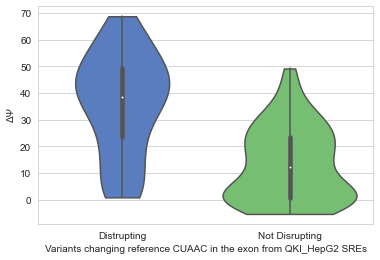

In [35]:

def sourced_violinplot(RBP_source, kmer, region):
    CLES, pval = stats.mannwhitneyu(x = matched_kmer_dpsis_RBP[RBP_source][region][kmer]['with'],
                                                 y = matched_kmer_dpsis_RBP[RBP_source][region][kmer]['without'], alternative = 'two-sided')
    CLES = CLES/(len(matched_kmer_dpsis_RBP[RBP_source][region][kmer]['with'])*len(matched_kmer_dpsis_RBP[RBP_source][region][kmer]['without']))

    print('n_with: ', len(matched_kmer_dpsis_RBP[RBP_source][region][kmer]['with']))
    print('n_without: ', len(matched_kmer_dpsis_RBP[RBP_source][region][kmer]['without']))
    print(CLES, pval)
    print(RBP_pval_dicts[RBP_source].loc[kmer][region + '_BH'])

    plot_df = pd.DataFrame({'kmer_status': ['Distrupting']* len(matched_kmer_dpsis_RBP[RBP_source][region][kmer]['with']) + 
                                           ['Not Disrupting']* len(matched_kmer_dpsis_RBP[RBP_source][region][kmer]['without']), 
                            'delta_psi': matched_kmer_dpsis_RBP[RBP_source][region][kmer]['with'] + matched_kmer_dpsis_RBP[RBP_source][region][kmer]['without']})
    sns.violinplot(x = 'kmer_status', y = 'delta_psi', data = plot_df, cut = 0)
    if region == 'exon':
        transition = ''
    else:
        transition = ' intron '
    plt.ylabel(u'\u0394\u03A8')
    plt.xlabel('Variants changing reference ' + kmer.replace('T','U') + ' in the ' + region + transition + ' from ' + RBP_source + ' SREs')
    
    
sourced_violinplot('SRSF1_HepG2', 'CTGGA', 'exon')
#plt.savefig(figure_out_dir + 'Figure_4C_SRSF1_HepG2_CUGGA_violinplot.svg')
#plt.savefig(figure_out_dir + 'Figure_4C_SRSF1_HepG2_CUGGA_violinplot.png')
plt.clf()

sourced_violinplot('RBFOX2_HepG2', 'GCATG', 'downstream')
#plt.savefig(figure_out_dir + 'Figure_4D_RBFOX2_HepG2_GCATG_violinplot.svg')
#plt.savefig(figure_out_dir + 'Figure_4D_RBFOX2_HepG2_GCATG_violinplot.png')
plt.clf()

sourced_violinplot('QKI_HepG2', 'CTAAC', 'exon')
#plt.savefig(figure_out_dir + 'Figure_4E_QKI_HepG2_CTAAC_violinplot.svg')
#plt.savefig(figure_out_dir + 'Figure_4E_QKI_HepG2_CTAAC_violinplot.png')
